# Compute IMERG precipitation climatology for SEEPS

In [1]:
import os
import sys
import yaml
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sys.path.insert(0, os.path.realpath('../libs/'))
import verif_utils as vu
import seeps_utils as seeps

In [4]:
config_name = os.path.realpath('verif_config.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

In [12]:
# ---------------------------------------------------------------------------------------- #
# ERA5 verif target
filename_ERA5 = sorted(glob('/glade/campaign/cisl/aiml/ksha/IMERG_V7/GPM_3B_V07/year_*_1deg_interp.zarr'))

# pick years
year_range = [2000, 2020]
years_pick = np.arange(year_range[0], year_range[1]+1, 1).astype(str)
filename_ERA5 = [fn for fn in filename_ERA5 if any(year in fn for year in years_pick)]

# merge yearly ERA5 as one
ds_ERA5 = [vu.get_forward_data(fn) for fn in filename_ERA5]
ds_ERA5_merge = xr.concat(ds_ERA5, dim='time')

variable_levels = {
    'total_precipitation': None,
}

ds_target = ds_ERA5_merge
ds_target = vu.ds_subset_everything(ds_target, variable_levels)

In [13]:
thres_calc = seeps.SEEPSThreshold(dry_threshold_mm=0.25, var='total_precipitation')
ds_clim = thres_calc.compute(ds_target, dim='time')

save_name = conf['ERA5_weatherbench']['save_loc_clim'] + 'IMERG_clim_2000_2020_SEEPS.nc'
# ds_clim.to_netcdf(save_name, mode='w')

In [14]:
ds_clim.to_netcdf(save_name, mode='w')

In [15]:
ds_clim = xr.open_dataset(
    '/glade/campaign/cisl/aiml/ksha/CREDIT_physics/VERIF/ERA5_clim/IMERG_clim_2000_2020_SEEPS.nc'
)

In [18]:
thers = ds_clim['total_precipitation_seeps_threshold'].values
thers[np.isnan(thers)] = 0.0

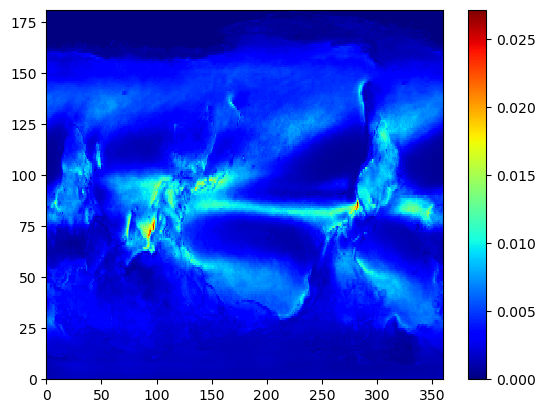

In [19]:
plt.pcolormesh(thers, cmap=plt.cm.jet)
plt.colorbar()